# DTSA 5511 - Final Project



**Name:** SungHak Hong

**Github:** 
## 1. Introduction and Problem Description

In this project, we will explore the News Category Dataset from Kaggle. The objective of this competition is using ktrain, predict the probability of specific category in news article dataset.

The dataset contains around 210,000 news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. HuffPost stopped maintaining an extensive archive of news articles sometime after this dataset was first collected in 2018, so it is not possible to collect such a dataset in the present day. Due to changes in the website, there are about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022.

In this Jupyter notebook, I will build a deep learning algorithm that predicts the probability of specific category using ktrain. ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, ktrain is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

The dataset and competition details can be found at the following link:

https://www.kaggle.com/datasets/rmisra/news-category-dataset?select=News_Category_Dataset_v3.json

## 2. EDA Procedure
### Import Library

In [1]:
import pandas as pd
import numpy as np
import ktrain
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from ktrain import text

### Importing the data

In [2]:
df = pd.read_json('../Final/News_Category_Dataset_v3.json', lines = True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [3]:
# Check the dimensions and data types of the DataFrame
print(df.shape)
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

(209527, 6)
link                         object
headline                     object
category                     object
short_description            object
authors                      object
date                 datetime64[ns]
dtype: object
link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64


The dataset has 6 features - link, headline, category, short_description, authors, and date. And there are 209527 data total that we can train and test the deep learning.

### Visualizations

<AxesSubplot:>

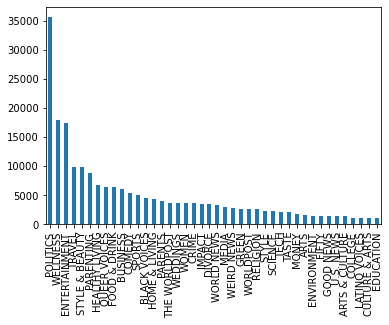

In [4]:
#Visualize the distribution of the category in dataframe
df['category'].value_counts().plot(kind='bar')

According to the visualization, the most category among the articles is politics. In this project, I am going to build a model that is able to distinguish the category. 

## 3. Build and Training Model

### Preprocessing

To perform ktrain learning, we first need to combine texts of headline and description. Also I created another column if given article is politics (1) or not(0).

In [5]:
# Aggregates the data
df['content'] = df['headline'] + ' ' + df['short_description']
df['isPolitics'] = np.where(df['category'].isin(['POLITICS']), 1, 0)

In [6]:
df.head()

,link,headline,category,short_description,authors,date,content,isPolitics
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,0
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",0
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,0
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,0
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,0


### Model Building and Training


I am going to try and optimize a BERT model by tuning the hyperparameters to see which model gives us the highest F1 score

In [7]:
# Create the balanced data
# Reduce sample amount to 1000 for fast build
sample_amount = 1000
class_prop = 0.5

politics = df[df['isPolitics'] == 1].sample(n=int(sample_amount*class_prop))
not_politics = df[df['isPolitics'] == 0].sample(n=int(sample_amount*(1-class_prop)))
train_sample_1 = pd.concat([politics,not_politics])

print(train_sample_1.describe())

       isPolitics
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000


In [8]:
# train, val, preprocess features for model
train, val, preproc = ktrain.text.texts_from_df(
    train_sample_1,
    "content",
    label_columns=["isPolitics"],
    val_df=None,
    max_features=1000, 
    maxlen=100, 
    val_pct=0.2, 
    ngram_range=1, 
    preprocess_mode="bert", 
    verbose=1
)  

#Set a batch size
batch_size = 6

#Build Model
model_1 = ktrain.text.text_classifier('bert', train_data=train, preproc=preproc)
learner_1 = ktrain.get_learner(model_1, train_data=train, val_data=val, batch_size=batch_size)

['not_isPolitics', 'isPolitics']
       not_isPolitics  isPolitics
84621             0.0         1.0
41331             0.0         1.0
52657             1.0         0.0
68676             1.0         0.0
38592             0.0         1.0
['not_isPolitics', 'isPolitics']
        not_isPolitics  isPolitics
70860              0.0         1.0
147253             1.0         0.0
169240             1.0         0.0
57306              1.0         0.0
161162             1.0         0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 100


C:\Users\vmfl7\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
134/134 [==============================] - 294s 2s/step - loss: 0.8243 - accuracy: 0.5088
Epoch 2/6
134/134 [==============================] - 276s 2s/step - loss: 0.5232 - accuracy: 0.7575
Epoch 3/6
134/134 [==============================] - 289s 2s/step - loss: 0.5671 - accuracy: 0.7287
Epoch 4/6
134/134 [==============================] - 287s 2s/step - loss: 1.3376 - accuracy: 0.4988
Epoch 5/6
134/134 [==============================] - 15s 95ms/step - loss: 6.3438 - accuracy: 0.6667


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.
0.00030379925738088787


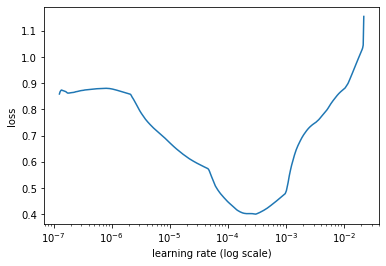

NameError: name 'learner' is not defined

In [9]:
# Learning Rate estimate 
learner_1.lr_find(max_epochs=6) # limited to 3 epoch for faster computation
lr = learner_1.lr_estimate()[1]*10
print(lr)
learner_1.lr_plot()

In [10]:
# Overfitting test
history=learner_1.autofit(
    lr,
    epochs=6, 
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.00030379925738088787...
Epoch 1/6
134/134 [==============================] - 377s 3s/step - loss: 0.6867 - accuracy: 0.5863 - val_loss: 0.6979 - val_accuracy: 0.4900
Epoch 2/6
134/134 [==============================] - 365s 3s/step - loss: 0.7228 - accuracy: 0.5100 - val_loss: 0.7342 - val_accuracy: 0.4900
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [12]:
# Predictor and Validation with model
predictor = ktrain.get_predictor(learner_1.model, preproc=preproc)

# results against validation set 
validation = learner_1.validate(val_data=val, print_report=True)

7/7 [==============================] - 23s 3s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.49      1.00      0.66        98

    accuracy                           0.49       200
   macro avg       0.24      0.50      0.33       200
weighted avg       0.24      0.49      0.32       200



C:\Users\vmfl7\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vmfl7\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vmfl7\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Adjust the class proportion at 0.25 

In [13]:
# Create the balanced data at 25% of politics news
sample_amount = 1000
class_prop = 0.25
batch_size = 6


politics = df[df['isPolitics'] == 1].sample(n=int(sample_amount*class_prop))
not_politics = df[df['isPolitics'] == 0].sample(n=int(sample_amount*(1-class_prop)))
train_sample_2 = pd.concat([politics,not_politics])

# Feature Extraction
train_02, val_02, preproc_2 = ktrain.text.texts_from_df(
    train_sample_2,
    "content",
    label_columns=["isPolitics"],
    val_df=None,
    max_features=1000, 
    maxlen=100, 
    val_pct=0.2, 
    ngram_range=1, 
    preprocess_mode="bert", 
    verbose=1
)  

# Model
model_02 = ktrain.text.text_classifier('bert', train_data=train_02, preproc=preproc_2)
learner_02 = ktrain.get_learner(model_02, train_data=train_02, val_data=val_02, batch_size=batch_size)


['not_isPolitics', 'isPolitics']
        not_isPolitics  isPolitics
95557              1.0         0.0
96249              0.0         1.0
10310              0.0         1.0
77948              0.0         1.0
205603             1.0         0.0
['not_isPolitics', 'isPolitics']
       not_isPolitics  isPolitics
4187              1.0         0.0
7558              0.0         1.0
65829             1.0         0.0
42704             1.0         0.0
65111             0.0         1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 100


C:\Users\vmfl7\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
134/134 [==============================] - 349s 2s/step - loss: 0.7200 - accuracy: 0.5163
Epoch 2/6
134/134 [==============================] - 375s 3s/step - loss: 0.3835 - accuracy: 0.8188
Epoch 3/6
134/134 [==============================] - 371s 3s/step - loss: 0.5165 - accuracy: 0.7675
Epoch 4/6
134/134 [==============================] - 370s 3s/step - loss: 1.4976 - accuracy: 0.6438
Epoch 5/6
134/134 [==============================] - 22s 143ms/step - loss: 6.4408 - accuracy: 0.5625


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.
0.00019657672964967787


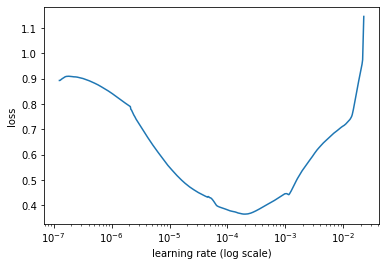

In [14]:
# Learning Rate estimate 
learner_02.lr_find(max_epochs=6) # limited to 3 epoch for faster computation
lr_02 = learner_02.lr_estimate()[1]*10
print(lr_02)
learner_02.lr_plot()

In [15]:
# Check to ensure we are not overfitting 
history=learner_02.autofit(
    lr_02,
    epochs=6, 
    early_stopping=True
)

# trained model 
predictor_02 = ktrain.get_predictor(learner_02.model, preproc=preproc_2)

# results against validation set 
validation_02 = learner_02.validate(val_data=val_02, print_report=True)



begin training using triangular learning rate policy with max lr of 0.00019657672964967787...
Epoch 1/6
134/134 [==============================] - 420s 3s/step - loss: 0.4950 - accuracy: 0.7312 - val_loss: 0.3400 - val_accuracy: 0.8500
Epoch 2/6
134/134 [==============================] - 394s 3s/step - loss: 0.4308 - accuracy: 0.8112 - val_loss: 0.5604 - val_accuracy: 0.8050
Epoch 2: early stopping
Weights from best epoch have been loaded into model.
7/7 [==============================] - 22s 3s/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       151
           1       0.67      0.76      0.71        49

    accuracy                           0.85       200
   macro avg       0.79      0.82      0.81       200
weighted avg       0.86      0.85      0.85       200



## 4. Conclusion